# Cylcoid Fitting

## Load Cyloid Data Points and Split into Arcs

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import curves.bezier as bezier
import curves.fitCurves as fit
import StressTools as tools
import utils
import fitting


interior = utils.import_interior('interior1')

TOLERANCE = 1

min_vals = np.array([0, 0.1, 0])
max_vals = np.array([360, 1, 360])
constraints = [
    dict(wrapValue=True, minValue=1e-8, maxValue=1),
    dict(minValue=1e-8, maxValue=1, unstick=True),
    dict(wrapValue=True, minValue=0, maxValue=1)
]
    

In [2]:
def createCycloidBezier(arcs, pointsPerCurve=100, maxError=0.05):
    all_curves = None

    for index, arc in enumerate(arcs):
        startingPoint = all_curves.shape[0] + 1 if all_curves is not None else 1
        curve = fitting.fit_arc(arc, 
                                startingPoint=startingPoint, 
                                output_points=pointsPerCurve, 
                                max_error=maxError)
        all_curves = curve if all_curves is None else pd.concat([all_curves, curve], ignore_index=True)
        
    return all_curves


### Delphi

In [3]:
delphi = pd.read_csv("./obsData/DelphiLonLatAT.txt", header=None, sep=' ', names=['lon', 'lat'])
delphi = delphi.sort_values(['lon', 'lat'])

delphi_arcs = [
    delphi[0:9],
    delphi[9:18],
    delphi[18:27],
    delphi[27:34],
    delphi[34:]
]

delphiCurve = createCycloidBezier(delphi_arcs)

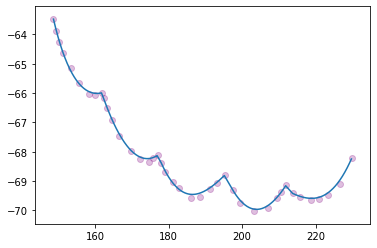

In [4]:
plt.plot(delphiCurve['lon'], delphiCurve['lat'])
plt.scatter(delphi['lon'], delphi['lat'], color='purple', alpha=0.25)

### Alex

In [5]:
alex = pd.read_csv("./obsData/AlexLonLatCut.txt", header=None, sep=' ', names=['lon', 'lat'])
alex = alex.sort_values(['lon', 'lat'])

alex_arcs = [
    alex[0:26],
    alex[26:50],
    alex[50:]
]

alexCurve = createCycloidBezier(alex_arcs, maxError=0.01135)

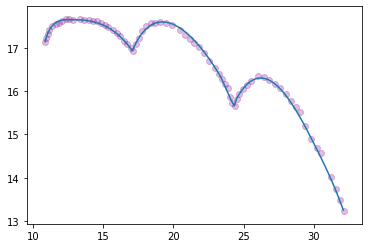

In [6]:
plt.plot(alexCurve['lon'], alexCurve['lat'])
plt.scatter(alex['lon'], alex['lat'], color='purple', alpha=0.25)

### Tyrrel

In [7]:
tyrrel = pd.read_csv("./obsData/TyrrelLonLat2.txt", header=None, sep=' ', names=['lon', 'lat'])
tyrrel = tyrrel.sort_values(['lon', 'lat'])

tyrrel_arcs = [
    tyrrel[0:13],
    tyrrel[13:25],
    tyrrel[25:40],
    tyrrel[40:53],
    tyrrel[53:59],
    tyrrel[59:63],
    tyrrel[63:74],
    tyrrel[74:84],
    tyrrel[84:95],
    tyrrel[95:]
]

tyrrelCurve = createCycloidBezier(tyrrel_arcs, maxError=0.01135)

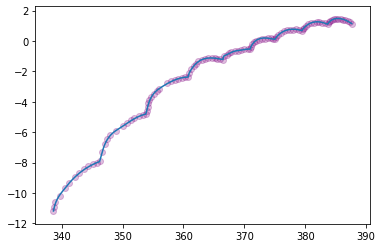

In [8]:
plt.plot(tyrrelCurve['lon'], tyrrelCurve['lat'])
plt.scatter(tyrrel['lon'], tyrrel['lat'], color='purple', alpha=0.25)

### Helper Functions

In [19]:
def translate_params(params, minVals, maxVals):
    if len(params) == 3:
        variables = params * (max_vals - min_vals) + min_vals # denormalize
    else:
        variables = params * (max_vals[0:2:] - min_vals[0:2:]) + min_vals[0:2:]
        
    return variables

def setChartXLimit(points, plt):
    BUFFER_PERCENT = 0.025
    
    first = points['lon'].max()
    last = points['lon'].min()
    
    buffer = (first - last) * BUFFER_PERCENT
    
    plt.xlim(first + buffer, last - buffer)


def check_fit(params, minVals, maxVals, curve, interior, tolerance=0.25):
    
    if len(params) == 3:
        variables = params * (max_vals - min_vals) + min_vals # denormalize
    else:
        variables = params * (max_vals[0:2:] - min_vals[0:2:]) + min_vals[0:2:]
        
    plt.figure()
    data = fitting.match_stresses(curve, variables, interior)
    fit_points = data.loc[data['deltaHeading'] < tolerance].copy()
    
    if len(variables) >= 3:
        fit_points['lon'] = fit_points['lon'] - variables[2]
    
    plt.plot(curve['lon'], curve['lat'])
    setChartXLimit(curve, plt)
    
    plt.scatter(fit_points['lon'], fit_points['lat'], alpha=0.3, color='green')
    
    plt.figure()
    
    plt.scatter(fit_points['pointNumber'], fit_points['stress'])
    
    print(np.array(variables))
    return data

## Perform Fits

### Tyrrel

In [46]:
numParams = 2
start_params = [np.random.rand() for iter in range(numParams)]
# start_params = [0.82787206, 0.35201265, 0.78423926]
# start_params = [0.221, 0.558]
# start_params = [0.12218236, 0.62424572]
start_params = [0.221, 0.65011694]

optimizer = fitting.Adam(alpha=0.05)

opt = optimizer.minimize(
    fitting.test_stress_parameters, 
    tyrrelCurve, 
    start_params, 
    interior,
    constraints=constraints,
    max_iterations=3000,
    verbose=True,
    batch_size=16
)

Iteration 1/3000 -- Loss Output: 0.038896147205498846 -- Moving Avg Loss: 0.038896147205498846
	Parameters used: [0.221, 0.65011694]
Iteration 2/3000 -- Loss Output: 1.2676608699485712 -- Moving Avg Loss: 0.6532785085770351
	Parameters used: [0.17100001 0.60011697]
Iteration 3/3000 -- Loss Output: 0.06605837499716084 -- Moving Avg Loss: 0.4575384640504103
	Parameters used: [0.13152477 0.56211652]
Iteration 4/3000 -- Loss Output: 0.06307551076283634 -- Moving Avg Loss: 0.3589227257285168
	Parameters used: [0.09853103 0.52920206]
Iteration 5/3000 -- Loss Output: 0.22093037032035412 -- Moving Avg Loss: 0.33132425464688425
	Parameters used: [0.06978274 0.50057694]
Iteration 6/3000 -- Loss Output: 2.031200405187459 -- Moving Avg Loss: 0.6146369464036466
	Parameters used: [0.04489209 0.47580973]
Iteration 7/3000 -- Loss Output: 2.4992591408901164 -- Moving Avg Loss: 0.8838686884731423
	Parameters used: [0.01843436 0.44934218]
Iteration 8/3000 -- Loss Output: 3.534480882848034 -- Moving Avg L

Iteration 63/3000 -- Loss Output: 3.5756818262030743 -- Moving Avg Loss: 2.2642828178184384
	Parameters used: [0.00523991 0.69329768]
Iteration 64/3000 -- Loss Output: 3.743738183697887 -- Moving Avg Loss: 2.3887965203537544
	Parameters used: [0.99951682 0.68779032]
Iteration 65/3000 -- Loss Output: 5.105642453795893 -- Moving Avg Loss: 2.5790409632128
	Parameters used: [0.99432728 0.68229901]
Iteration 66/3000 -- Loss Output: 5.756365431340101 -- Moving Avg Loss: 2.715107608246888
	Parameters used: [0.9891234  0.67681657]
Iteration 67/3000 -- Loss Output: 6.237111971732119 -- Moving Avg Loss: 2.8196876380178413
	Parameters used: [0.98397944 0.67141395]
Iteration 68/3000 -- Loss Output: 4.619868323044469 -- Moving Avg Loss: 2.9817428083368913
	Parameters used: [0.97845106 0.6656361 ]
Iteration 69/3000 -- Loss Output: 7.686347514930012 -- Moving Avg Loss: 3.2830340421612805
	Parameters used: [0.96674162 0.65356004]
Iteration 70/3000 -- Loss Output: 4.245998873273906 -- Moving Avg Loss: 

Iteration 125/3000 -- Loss Output: 11.53546196053237 -- Moving Avg Loss: 3.647119600186358
	Parameters used: [0.86668167 0.08907866]
Iteration 126/3000 -- Loss Output: 9.652477683279162 -- Moving Avg Loss: 3.9843712144468086
	Parameters used: [0.84020414 0.06198512]
Iteration 127/3000 -- Loss Output: 9.018947189843722 -- Moving Avg Loss: 4.342083431378546
	Parameters used: [0.80197158 0.02292567]
Iteration 128/3000 -- Loss Output: 10.510131912525955 -- Moving Avg Loss: 4.70926001227564
	Parameters used: [0.76660984 0.44883775]
Iteration 129/3000 -- Loss Output: 11.083506074858178 -- Moving Avg Loss: 5.05473036529663
	Parameters used: [0.71588426 0.41821091]
Iteration 130/3000 -- Loss Output: 11.777441697556606 -- Moving Avg Loss: 5.519072192625238
	Parameters used: [0.66881782 0.38823815]
Iteration 131/3000 -- Loss Output: 9.461701686985405 -- Moving Avg Loss: 5.798913169062444
	Parameters used: [0.61390998 0.34068483]
Iteration 132/3000 -- Loss Output: 13.439724498752428 -- Moving Avg

Iteration 187/3000 -- Loss Output: 12.472143595794416 -- Moving Avg Loss: 8.555653038238928
	Parameters used: [0.53477045 0.33436473]
Iteration 188/3000 -- Loss Output: 4.011006289250169 -- Moving Avg Loss: 8.462258297154845
	Parameters used: [0.49356632 0.29216194]
Iteration 189/3000 -- Loss Output: 4.629192862058644 -- Moving Avg Loss: 8.43949016184894
	Parameters used: [0.45627224 0.25396368]
Iteration 190/3000 -- Loss Output: 4.476228934962121 -- Moving Avg Loss: 8.330639927661254
	Parameters used: [0.42259021 0.21946498]
Iteration 191/3000 -- Loss Output: 2.807702767177835 -- Moving Avg Loss: 8.141502163549141
	Parameters used: [0.3920039  0.18813654]
Iteration 192/3000 -- Loss Output: 1.501794543476667 -- Moving Avg Loss: 7.8268410680020315
	Parameters used: [0.36394566 0.15939627]
Iteration 193/3000 -- Loss Output: 1.5974469133659992 -- Moving Avg Loss: 7.650768307967557
	Parameters used: [0.33859471 0.13342902]
Iteration 194/3000 -- Loss Output: 2.7670107466605898 -- Moving Avg

Iteration 248/3000 -- Loss Output: 3.3530949221635074 -- Moving Avg Loss: 1.7568519898644956
	Parameters used: [0.00896656 0.453052  ]
Iteration 249/3000 -- Loss Output: 4.555727810430579 -- Moving Avg Loss: 1.9172954234914044
	Parameters used: [0.00464425 0.44861887]
Iteration 250/3000 -- Loss Output: 3.9663065956866337 -- Moving Avg Loss: 2.0729840910560533
	Parameters used: [0.00053817 0.44440752]
Iteration 251/3000 -- Loss Output: 5.023584453905059 -- Moving Avg Loss: 2.2447427977250936
	Parameters used: [0.99620688 0.43996519]
Iteration 252/3000 -- Loss Output: 3.6878076058545552 -- Moving Avg Loss: 2.388576234666297
	Parameters used: [0.99230027 0.43587415]
Iteration 253/3000 -- Loss Output: 5.008408529559615 -- Moving Avg Loss: 2.5845389132300305
	Parameters used: [0.98646234 0.42985953]
Iteration 254/3000 -- Loss Output: 2.9118732589344045 -- Moving Avg Loss: 2.6970231083294505
	Parameters used: [0.98075021 0.42397865]
Iteration 255/3000 -- Loss Output: 3.0101910648293293 -- Mo

Iteration 310/3000 -- Loss Output: 14.468497348769764 -- Moving Avg Loss: 6.863199077230532
	Parameters used: [0.50848928 0.69784543]
Iteration 311/3000 -- Loss Output: 7.129313180363947 -- Moving Avg Loss: 7.030892568138091
	Parameters used: [0.48502418 0.67441577]
Iteration 312/3000 -- Loss Output: 8.600086984833998 -- Moving Avg Loss: 7.26532672155255
	Parameters used: [0.46374446 0.65316801]
Iteration 313/3000 -- Loss Output: 7.499085094038848 -- Moving Avg Loss: 7.403337218462813
	Parameters used: [0.44449112 0.6339435 ]
Iteration 314/3000 -- Loss Output: 4.543396571347154 -- Moving Avg Loss: 7.428697866029778
	Parameters used: [0.4270698  0.61654817]
Iteration 315/3000 -- Loss Output: 5.199317443134884 -- Moving Avg Loss: 7.472448686543731
	Parameters used: [0.41119241 0.60069424]
Iteration 316/3000 -- Loss Output: 5.78119765267845 -- Moving Avg Loss: 7.5302532568520375
	Parameters used: [0.39673216 0.58625515]
Iteration 317/3000 -- Loss Output: 5.473921114470519 -- Moving Avg Lo

Iteration 372/3000 -- Loss Output: 0.06512830004923466 -- Moving Avg Loss: 0.9394686779532008
	Parameters used: [0.18773744 0.37749485]
Iteration 373/3000 -- Loss Output: 3.0476178551303916 -- Moving Avg Loss: 1.0534968349408507
	Parameters used: [0.18665202 0.37641029]
Iteration 374/3000 -- Loss Output: 1.903775591574082 -- Moving Avg Loss: 1.0690946437285802
	Parameters used: [0.18564803 0.37540709]
Iteration 375/3000 -- Loss Output: 0.07344813381162192 -- Moving Avg Loss: 1.009508639391026
	Parameters used: [0.1840497  0.37381004]
Iteration 376/3000 -- Loss Output: 1.8171614636411868 -- Moving Avg Loss: 1.0560098696955427
	Parameters used: [0.18259825 0.37235973]
Iteration 377/3000 -- Loss Output: 0.18812514932870547 -- Moving Avg Loss: 0.970358719920032
	Parameters used: [0.181261   0.37102355]
Iteration 378/3000 -- Loss Output: 1.1896935025436506 -- Moving Avg Loss: 1.0112639473072507
	Parameters used: [0.17999401 0.36975756]
Iteration 379/3000 -- Loss Output: 0.9579401659504277 -

Iteration 433/3000 -- Loss Output: 1.5882050371069947 -- Moving Avg Loss: 1.7298931971892337
	Parameters used: [0.04898678 0.23885417]
Iteration 434/3000 -- Loss Output: 0.9338513125419717 -- Moving Avg Loss: 1.707900606844428
	Parameters used: [0.04594121 0.235811  ]
Iteration 435/3000 -- Loss Output: 0.18775772112299421 -- Moving Avg Loss: 1.6421424198794634
	Parameters used: [0.04315848 0.23303048]
Iteration 436/3000 -- Loss Output: 3.8623754094068525 -- Moving Avg Loss: 1.7728556419574897
	Parameters used: [0.04058428 0.23045832]
Iteration 437/3000 -- Loss Output: 1.4345181040654742 -- Moving Avg Loss: 1.7788200518770998
	Parameters used: [0.03824935 0.22812524]
Iteration 438/3000 -- Loss Output: 2.344057587026447 -- Moving Avg Loss: 1.8169894170270167
	Parameters used: [0.03565599 0.22553394]
Iteration 439/3000 -- Loss Output: 1.4637823965322796 -- Moving Avg Loss: 1.7744915441396134
	Parameters used: [0.03331851 0.2231983 ]
Iteration 440/3000 -- Loss Output: 3.0810406624537525 --

Iteration 495/3000 -- Loss Output: 1.8302046637543161 -- Moving Avg Loss: 7.84072525339373
	Parameters used: [0.33070573 0.00549197]
Iteration 496/3000 -- Loss Output: 3.2007101997679075 -- Moving Avg Loss: 7.521552134487274
	Parameters used: [0.31620037 0.10488442]
Iteration 497/3000 -- Loss Output: 2.0684647930108664 -- Moving Avg Loss: 7.1383519059540905
	Parameters used: [0.30281746 0.09196559]
Iteration 498/3000 -- Loss Output: 5.163354281813674 -- Moving Avg Loss: 6.879597879543991
	Parameters used: [0.29068521 0.08024911]
Iteration 499/3000 -- Loss Output: 4.0480175471964115 -- Moving Avg Loss: 6.636945400907179
	Parameters used: [0.27877887 0.0686848 ]
Iteration 500/3000 -- Loss Output: 5.676652013303767 -- Moving Avg Loss: 6.442573249187345
	Parameters used: [0.26725464 0.05744683]
Iteration 501/3000 -- Loss Output: 2.488703865452468 -- Moving Avg Loss: 6.210481467440132
	Parameters used: [0.25677678 0.04722476]
Iteration 502/3000 -- Loss Output: 3.9643998813706274 -- Moving A

Iteration 557/3000 -- Loss Output: 2.7020237206760007 -- Moving Avg Loss: 1.7850053317554406
	Parameters used: [0.01996208 0.25894541]
Iteration 558/3000 -- Loss Output: 2.0369066203634434 -- Moving Avg Loss: 1.7770888693251257
	Parameters used: [0.0137754  0.25276509]
Iteration 559/3000 -- Loss Output: 2.6217932366796 -- Moving Avg Loss: 1.8793515286960953
	Parameters used: [0.00764374 0.24663965]
Iteration 560/3000 -- Loss Output: 2.2033839385082294 -- Moving Avg Loss: 1.924124353614425
	Parameters used: [0.00029119 0.23929432]
Iteration 561/3000 -- Loss Output: 1.7896367839447842 -- Moving Avg Loss: 1.8867317743388095
	Parameters used: [0.99325289 0.23226293]
Iteration 562/3000 -- Loss Output: 1.9342892532762408 -- Moving Avg Loss: 1.9595459410058411
	Parameters used: [0.9869129  0.22566559]
Iteration 563/3000 -- Loss Output: 2.3052609095862207 -- Moving Avg Loss: 2.0179576196689215
	Parameters used: [0.98106371 0.21959009]
Iteration 564/3000 -- Loss Output: 2.8479232296942567 -- Mo

Iteration 619/3000 -- Loss Output: 1.018388255539685 -- Moving Avg Loss: 1.107297382408018
	Parameters used: [0.12359069 0.61580154]
Iteration 620/3000 -- Loss Output: 0.08075327980216222 -- Moving Avg Loss: 0.9972074625075511
	Parameters used: [0.12119799 0.6135513 ]
Iteration 621/3000 -- Loss Output: 0.7536950563974877 -- Moving Avg Loss: 0.8579160964689179
	Parameters used: [0.11903773 0.61151925]
Iteration 622/3000 -- Loss Output: 1.053149018790948 -- Moving Avg Loss: 0.744655163815881
	Parameters used: [0.11708761 0.60968453]
Iteration 623/3000 -- Loss Output: 0.09637975134634827 -- Moving Avg Loss: 0.7088883073305997
	Parameters used: [0.11528649 0.60798598]
Iteration 624/3000 -- Loss Output: 0.05262543636985706 -- Moving Avg Loss: 0.6860289994585834
	Parameters used: [0.11282124 0.60558854]
Iteration 625/3000 -- Loss Output: 0.21862847859487958 -- Moving Avg Loss: 0.5820843569611839
	Parameters used: [0.11059791 0.60342631]
Iteration 626/3000 -- Loss Output: 0.07145947011700894 

Iteration 680/3000 -- Loss Output: 4.0655246918079975 -- Moving Avg Loss: 3.652092611542394
	Parameters used: [0.93443757 0.42174108]
Iteration 681/3000 -- Loss Output: 9.594931248758167 -- Moving Avg Loss: 3.9897126712547766
	Parameters used: [0.92911613 0.41625225]
Iteration 682/3000 -- Loss Output: 5.420057066827193 -- Moving Avg Loss: 4.147400856834378
	Parameters used: [0.92331185 0.41035679]
Iteration 683/3000 -- Loss Output: 6.652501318408827 -- Moving Avg Loss: 4.362644847299102
	Parameters used: [0.91790081 0.40487168]
Iteration 684/3000 -- Loss Output: 8.861265274589956 -- Moving Avg Loss: 4.653676914955504
	Parameters used: [0.91177443 0.39873179]
Iteration 685/3000 -- Loss Output: 8.05450951890101 -- Moving Avg Loss: 4.956189426211587
	Parameters used: [0.89519457 0.38248471]
Iteration 686/3000 -- Loss Output: 10.636021176980313 -- Moving Avg Loss: 5.241878233732514
	Parameters used: [0.87495035 0.36258871]
Iteration 687/3000 -- Loss Output: 8.413732090072603 -- Moving Avg 

Iteration 742/3000 -- Loss Output: 1.7166876402221323 -- Moving Avg Loss: 8.050280242684032
	Parameters used: [0.20229998 0.2088572 ]
Iteration 743/3000 -- Loss Output: 0.48116880303812637 -- Moving Avg Loss: 7.720645259534275
	Parameters used: [0.15782531 0.16469402]
Iteration 744/3000 -- Loss Output: 3.607236991240742 -- Moving Avg Loss: 7.564029745818413
	Parameters used: [0.11775889 0.12490822]
Iteration 745/3000 -- Loss Output: 1.210150691790058 -- Moving Avg Loss: 7.258931162597874
	Parameters used: [0.08166248 0.08906463]
Iteration 746/3000 -- Loss Output: 0.9645037000717326 -- Moving Avg Loss: 6.882995096492965
	Parameters used: [0.04912964 0.0567597 ]
Iteration 747/3000 -- Loss Output: 1.1222990384451585 -- Moving Avg Loss: 6.388560663132327
	Parameters used: [0.01980625 0.02764178]
Iteration 748/3000 -- Loss Output: 0.8226187163416521 -- Moving Avg Loss: 6.060366278301626
	Parameters used: [0.99338977 0.0014104 ]
Iteration 749/3000 -- Loss Output: 8.313422708099399 -- Moving 

Iteration 804/3000 -- Loss Output: 3.562810783115211 -- Moving Avg Loss: 3.571832967053112
	Parameters used: [0.29459043 0.17147185]
Iteration 805/3000 -- Loss Output: 3.440825563920834 -- Moving Avg Loss: 3.333243924809196
	Parameters used: [0.29148194 0.16838935]
Iteration 806/3000 -- Loss Output: 1.6270916611251256 -- Moving Avg Loss: 3.26478651311548
	Parameters used: [0.28720015 0.1641434 ]
Iteration 807/3000 -- Loss Output: 0.981011321690588 -- Moving Avg Loss: 3.098534323095482
	Parameters used: [0.28321265 0.16018926]
Iteration 808/3000 -- Loss Output: 3.7834542557592448 -- Moving Avg Loss: 3.072805726298418
	Parameters used: [0.27958727 0.15659423]
Iteration 809/3000 -- Loss Output: 4.2676297433952755 -- Moving Avg Loss: 3.0853100825960404
	Parameters used: [0.2760608  0.15309726]
Iteration 810/3000 -- Loss Output: 2.8732059645934314 -- Moving Avg Loss: 2.9837341465907503
	Parameters used: [0.27175546 0.14882797]
Iteration 811/3000 -- Loss Output: 0.1991947684851619 -- Moving 

Iteration 865/3000 -- Loss Output: 0.3137443486643668 -- Moving Avg Loss: 0.9407213608751769
	Parameters used: [0.08649012 0.8776004 ]
Iteration 866/3000 -- Loss Output: 0.06852728979546477 -- Moving Avg Loss: 0.856549997122397
	Parameters used: [0.08566214 0.87677961]
Iteration 867/3000 -- Loss Output: 0.0776106805781141 -- Moving Avg Loss: 0.8043712851802708
	Parameters used: [0.08491403 0.87603797]
Iteration 868/3000 -- Loss Output: 0.10483184338813553 -- Moving Avg Loss: 0.7738142139714301
	Parameters used: [0.08423683 0.87536664]
Iteration 869/3000 -- Loss Output: 0.12655563016693125 -- Moving Avg Loss: 0.7119189114492471
	Parameters used: [0.08362474 0.87475985]
Iteration 870/3000 -- Loss Output: 0.500446478685552 -- Moving Avg Loss: 0.589862020145084
	Parameters used: [0.08306406 0.87420402]
Iteration 871/3000 -- Loss Output: 0.08186764787392935 -- Moving Avg Loss: 0.3876607905471331
	Parameters used: [0.08111801 0.87227397]
Iteration 872/3000 -- Loss Output: 1.925298279677988 -

Iteration 926/3000 -- Loss Output: 4.162691247989948 -- Moving Avg Loss: 2.59090408377219
	Parameters used: [0.97445063 0.49388537]
Iteration 927/3000 -- Loss Output: 8.459498601946608 -- Moving Avg Loss: 2.689895379991613
	Parameters used: [0.96983027 0.48926819]
Iteration 928/3000 -- Loss Output: 6.424732372352935 -- Moving Avg Loss: 2.803993669768243
	Parameters used: [0.96561251 0.48505381]
Iteration 929/3000 -- Loss Output: 8.243055568625664 -- Moving Avg Loss: 3.0578815651574787
	Parameters used: [0.96161771 0.48106385]
Iteration 930/3000 -- Loss Output: 7.361260591726347 -- Moving Avg Loss: 3.2529208944043724
	Parameters used: [0.95613714 0.47560415]
Iteration 931/3000 -- Loss Output: 3.486737170730754 -- Moving Avg Loss: 3.2969623296243094
	Parameters used: [0.95111248 0.47059883]
Iteration 932/3000 -- Loss Output: 9.684217654184001 -- Moving Avg Loss: 3.614685664622438
	Parameters used: [0.94629516 0.46580072]
Iteration 933/3000 -- Loss Output: 10.18019379061685 -- Moving Avg 

Iteration 988/3000 -- Loss Output: 1.7294816378157736 -- Moving Avg Loss: 4.547114038800439
	Parameters used: [0.33178117 0.72056823]
Iteration 989/3000 -- Loss Output: 1.423537886137012 -- Moving Avg Loss: 4.372530430157096
	Parameters used: [0.32846689 0.71727065]
Iteration 990/3000 -- Loss Output: 4.495717079709938 -- Moving Avg Loss: 4.420158299125477
	Parameters used: [0.32547175 0.71429061]
Iteration 991/3000 -- Loss Output: 1.7719741550314612 -- Moving Avg Loss: 4.327794735211759
	Parameters used: [0.32273669 0.7115693 ]
Iteration 992/3000 -- Loss Output: 4.084318379007063 -- Moving Avg Loss: 4.279653808529963
	Parameters used: [0.31997927 0.70882565]
Iteration 993/3000 -- Loss Output: 2.44987529554611 -- Moving Avg Loss: 4.188202438215112
	Parameters used: [0.31744282 0.70630184]
Iteration 994/3000 -- Loss Output: 4.483628027243662 -- Moving Avg Loss: 4.055423048963704
	Parameters used: [0.31459466 0.7034677 ]
Iteration 995/3000 -- Loss Output: 4.502344259684692 -- Moving Avg L

Iteration 1049/3000 -- Loss Output: 0.1330801700133697 -- Moving Avg Loss: 1.2179853179360152
	Parameters used: [0.10351804 0.49340133]
Iteration 1050/3000 -- Loss Output: 1.1418347910092503 -- Moving Avg Loss: 1.1977468693320943
	Parameters used: [0.10133059 0.4912243 ]
Iteration 1051/3000 -- Loss Output: 1.0311358697446296 -- Moving Avg Loss: 1.170530764371243
	Parameters used: [0.09935243 0.48925556]
Iteration 1052/3000 -- Loss Output: 2.455642166676823 -- Moving Avg Loss: 1.2069582762858304
	Parameters used: [0.09755055 0.48746226]
Iteration 1053/3000 -- Loss Output: 0.2738583081867045 -- Moving Avg Loss: 1.0725948868004427
	Parameters used: [0.09591458 0.48583409]
Iteration 1054/3000 -- Loss Output: 0.2289229337426596 -- Moving Avg Loss: 0.9819773766871398
	Parameters used: [0.09441611 0.48434276]
Iteration 1055/3000 -- Loss Output: 0.09857703798569731 -- Moving Avg Loss: 0.8543928388831854
	Parameters used: [0.0930361  0.48296933]
Iteration 1056/3000 -- Loss Output: 1.56206873411

Iteration 1110/3000 -- Loss Output: 1.5431397294344538 -- Moving Avg Loss: 2.539157387009219
	Parameters used: [0.02595183 0.41620664]
Iteration 1111/3000 -- Loss Output: 4.064488727736004 -- Moving Avg Loss: 2.637676631376841
	Parameters used: [0.02283361 0.41310338]
Iteration 1112/3000 -- Loss Output: 2.817411090179677 -- Moving Avg Loss: 2.728342611442476
	Parameters used: [0.02000683 0.41029016]
Iteration 1113/3000 -- Loss Output: 3.206085825602346 -- Moving Avg Loss: 2.72743951003288
	Parameters used: [0.01634295 0.40664385]
Iteration 1114/3000 -- Loss Output: 2.8215641449884568 -- Moving Avg Loss: 2.736521155248937
	Parameters used: [0.01302067 0.40333751]
Iteration 1115/3000 -- Loss Output: 3.7421936206945925 -- Moving Avg Loss: 2.863581409482663
	Parameters used: [0.00993328 0.40026493]
Iteration 1116/3000 -- Loss Output: 3.2967499027768397 -- Moving Avg Loss: 2.8163836326801954
	Parameters used: [0.00607792 0.39642806]
Iteration 1117/3000 -- Loss Output: 2.4758490467155214 -- 

Iteration 1171/3000 -- Loss Output: 13.004867825588095 -- Moving Avg Loss: 10.415184463150192
	Parameters used: [0.54692252 0.55312778]
Iteration 1172/3000 -- Loss Output: 12.954463271391667 -- Moving Avg Loss: 10.564198893795785
	Parameters used: [0.53479447 0.54164009]
Iteration 1173/3000 -- Loss Output: 12.394665221150902 -- Moving Avg Loss: 10.831235251417432
	Parameters used: [0.52365214 0.53106449]
Iteration 1174/3000 -- Loss Output: 11.117419403579733 -- Moving Avg Loss: 10.891461165405252
	Parameters used: [0.50685989 0.51448938]
Iteration 1175/3000 -- Loss Output: 6.3471796951975525 -- Moving Avg Loss: 10.882023113149222
	Parameters used: [0.49112814 0.49895121]
Iteration 1176/3000 -- Loss Output: 5.689252353632888 -- Moving Avg Loss: 10.700260938429063
	Parameters used: [0.4769476  0.48494499]
Iteration 1177/3000 -- Loss Output: 7.522931272112655 -- Moving Avg Loss: 10.526701351461657
	Parameters used: [0.46415602 0.47231035]
Iteration 1178/3000 -- Loss Output: 6.304024468890

Iteration 1232/3000 -- Loss Output: 1.9666246170493773 -- Moving Avg Loss: 2.0718911341509916
	Parameters used: [0.21692756 0.22694088]
Iteration 1233/3000 -- Loss Output: 1.712443581374105 -- Moving Avg Loss: 2.094736910001811
	Parameters used: [0.2147577  0.22478153]
Iteration 1234/3000 -- Loss Output: 1.7662125358681133 -- Moving Avg Loss: 2.138027505936077
	Parameters used: [0.21271356 0.22274731]
Iteration 1235/3000 -- Loss Output: 0.5909347205800246 -- Moving Avg Loss: 2.0676296499214852
	Parameters used: [0.21060152 0.2206455 ]
Iteration 1236/3000 -- Loss Output: 1.0067705340319844 -- Moving Avg Loss: 1.982206278659644
	Parameters used: [0.20868305 0.21873632]
Iteration 1237/3000 -- Loss Output: 0.49313972077391344 -- Moving Avg Loss: 1.915984428000811
	Parameters used: [0.20692626 0.21698805]
Iteration 1238/3000 -- Loss Output: 2.9857521361704435 -- Moving Avg Loss: 1.9917221193643844
	Parameters used: [0.20531217 0.21538179]
Iteration 1239/3000 -- Loss Output: 0.50847492555188

Iteration 1293/3000 -- Loss Output: 2.0002867568419442 -- Moving Avg Loss: 1.944770032888025
	Parameters used: [0.02887793 0.03980022]
Iteration 1294/3000 -- Loss Output: 2.603091722479887 -- Moving Avg Loss: 2.0456207450021378
	Parameters used: [0.02650381 0.03743759]
Iteration 1295/3000 -- Loss Output: 1.2522137691900301 -- Moving Avg Loss: 2.0862893791667023
	Parameters used: [0.02432449 0.03526881]
Iteration 1296/3000 -- Loss Output: 0.9478908625481912 -- Moving Avg Loss: 2.0721493118234027
	Parameters used: [0.022343  0.0332969]
Iteration 1297/3000 -- Loss Output: 4.492459683068055 -- Moving Avg Loss: 2.2032709102857946
	Parameters used: [0.01990387 0.03086957]
Iteration 1298/3000 -- Loss Output: 1.7789876527356492 -- Moving Avg Loss: 2.157136253110701
	Parameters used: [0.01767298 0.02864946]
Iteration 1299/3000 -- Loss Output: 2.444665779830302 -- Moving Avg Loss: 2.23422374871072
	Parameters used: [0.01559799 0.0265845 ]
Iteration 1300/3000 -- Loss Output: 1.5765722720883868 --

Iteration 1354/3000 -- Loss Output: 13.540050012339156 -- Moving Avg Loss: 10.674239536769914
	Parameters used: [0.61751046 0.16356637]
Iteration 1355/3000 -- Loss Output: 10.468407922306044 -- Moving Avg Loss: 10.757373394516762
	Parameters used: [0.59684496 0.14299767]
Iteration 1356/3000 -- Loss Output: 12.180553193809262 -- Moving Avg Loss: 10.820653931947732
	Parameters used: [0.57540958 0.1216627 ]
Iteration 1357/3000 -- Loss Output: 7.052523499548604 -- Moving Avg Loss: 10.736169486145066
	Parameters used: [0.55561594 0.10196178]
Iteration 1358/3000 -- Loss Output: 5.222334262446796 -- Moving Avg Loss: 10.453784483593584
	Parameters used: [0.53771189 0.0841416 ]
Iteration 1359/3000 -- Loss Output: 3.1845264198547194 -- Moving Avg Loss: 10.133478272253644
	Parameters used: [0.521456   0.06796187]
Iteration 1360/3000 -- Loss Output: 4.714087569838528 -- Moving Avg Loss: 9.980620267256429
	Parameters used: [0.506813   0.05338746]
Iteration 1361/3000 -- Loss Output: 3.94066593483977

Iteration 1415/3000 -- Loss Output: 0.1668004154105352 -- Moving Avg Loss: 2.1879265501768312
	Parameters used: [0.28405893 0.74879791]
Iteration 1416/3000 -- Loss Output: 1.644948895003179 -- Moving Avg Loss: 2.1488933326414896
	Parameters used: [0.282937   0.74768125]
Iteration 1417/3000 -- Loss Output: 1.5482548170929078 -- Moving Avg Loss: 2.0492682232152264
	Parameters used: [0.2818571  0.74660643]
Iteration 1418/3000 -- Loss Output: 2.368567758334351 -- Moving Avg Loss: 2.061370611556498
	Parameters used: [0.28048952 0.74524527]
Iteration 1419/3000 -- Loss Output: 3.1063998276060576 -- Moving Avg Loss: 2.0214567583838106
	Parameters used: [0.27918871 0.74395056]
Iteration 1420/3000 -- Loss Output: 3.163281705116493 -- Moving Avg Loss: 2.078109865901725
	Parameters used: [0.27784308 0.74261125]
Iteration 1421/3000 -- Loss Output: 3.4847928354384488 -- Moving Avg Loss: 1.9921266353105826
	Parameters used: [0.27636627 0.74114136]
Iteration 1422/3000 -- Loss Output: 0.063423156367706

Iteration 1476/3000 -- Loss Output: 0.2891480585002194 -- Moving Avg Loss: 0.572767375669882
	Parameters used: [0.23238937 0.69737073]
Iteration 1477/3000 -- Loss Output: 2.605082168504234 -- Moving Avg Loss: 0.6744389293975058
	Parameters used: [0.23192834 0.69691186]
Iteration 1478/3000 -- Loss Output: 0.879698720155714 -- Moving Avg Loss: 0.7058990677012639
	Parameters used: [0.23144932 0.69643509]
Iteration 1479/3000 -- Loss Output: 0.04803825926639315 -- Moving Avg Loss: 0.6980193070274657
	Parameters used: [0.23065561 0.6956451 ]
Iteration 1480/3000 -- Loss Output: 0.03501325538114508 -- Moving Avg Loss: 0.6970300141617581
	Parameters used: [0.22993775 0.69493061]
Iteration 1481/3000 -- Loss Output: 0.03764443005084832 -- Moving Avg Loss: 0.583369132815552
	Parameters used: [0.22929013 0.69428602]
Iteration 1482/3000 -- Loss Output: 1.393156338567605 -- Moving Avg Loss: 0.6374542986158761
	Parameters used: [0.22870663 0.69370526]
Iteration 1483/3000 -- Loss Output: 0.043205506462

Iteration 1537/3000 -- Loss Output: 0.5510604803079869 -- Moving Avg Loss: 0.41893975162904495
	Parameters used: [0.19695189 0.66209945]
Iteration 1538/3000 -- Loss Output: 0.0439177674836836 -- Moving Avg Loss: 0.419536087212048
	Parameters used: [0.1967226  0.66187123]
Iteration 1539/3000 -- Loss Output: 0.31183995939083936 -- Moving Avg Loss: 0.42967669802448955
	Parameters used: [0.19651331 0.66166293]
Iteration 1540/3000 -- Loss Output: 0.5797417342690728 -- Moving Avg Loss: 0.40185497780427354
	Parameters used: [0.19632235 0.66147286]
Iteration 1541/3000 -- Loss Output: 0.9198592936894601 -- Moving Avg Loss: 0.436377202753816
	Parameters used: [0.19610442 0.66125595]
Iteration 1542/3000 -- Loss Output: 0.8508840994616836 -- Moving Avg Loss: 0.40999000760255283
	Parameters used: [0.19574562 0.66089884]
Iteration 1543/3000 -- Loss Output: 0.05011508597769457 -- Moving Avg Loss: 0.40186172273393234
	Parameters used: [0.19537686 0.6605318 ]
Iteration 1544/3000 -- Loss Output: 2.61005

Iteration 1597/3000 -- Loss Output: 0.3359626552158036 -- Moving Avg Loss: 0.5097987361494918
	Parameters used: [0.1421264  0.60753105]
Iteration 1598/3000 -- Loss Output: 0.05119375175744403 -- Moving Avg Loss: 0.5099314472025304
	Parameters used: [0.14087973 0.60629022]
Iteration 1599/3000 -- Loss Output: 1.5175304937085106 -- Moving Avg Loss: 0.5589305452552505
	Parameters used: [0.13974999 0.60516578]
Iteration 1600/3000 -- Loss Output: 0.0391810488051773 -- Moving Avg Loss: 0.5576240780568478
	Parameters used: [0.13873592 0.60415646]
Iteration 1601/3000 -- Loss Output: 0.71594310126837 -- Moving Avg Loss: 0.564813165008475
	Parameters used: [0.13781217 0.60323704]
Iteration 1602/3000 -- Loss Output: 0.040638126494051414 -- Moving Avg Loss: 0.5638958523989595
	Parameters used: [0.13697778 0.60240657]
Iteration 1603/3000 -- Loss Output: 1.1758209649669908 -- Moving Avg Loss: 0.6090622068726893
	Parameters used: [0.13621745 0.60164981]
Iteration 1604/3000 -- Loss Output: 0.4119315637

Iteration 1658/3000 -- Loss Output: 9.410609906409096 -- Moving Avg Loss: 7.889855433265793
	Parameters used: [0.76622458 0.23322218]
Iteration 1659/3000 -- Loss Output: 11.57413544085315 -- Moving Avg Loss: 8.072876172523834
	Parameters used: [0.7534193  0.22047636]
Iteration 1660/3000 -- Loss Output: 10.968799478769347 -- Moving Avg Loss: 8.378641250276127
	Parameters used: [0.7386724  0.20579791]
Iteration 1661/3000 -- Loss Output: 11.282003997123569 -- Moving Avg Loss: 8.605796861724984
	Parameters used: [0.69999962 0.16729897]
Iteration 1662/3000 -- Loss Output: 11.87032797042492 -- Moving Avg Loss: 8.887694680641417
	Parameters used: [0.66417319 0.13163372]
Iteration 1663/3000 -- Loss Output: 10.079664572888358 -- Moving Avg Loss: 8.972682630878285
	Parameters used: [0.63162061 0.09922764]
Iteration 1664/3000 -- Loss Output: 7.690867952515975 -- Moving Avg Loss: 8.986481316725312
	Parameters used: [0.60214068 0.0698804 ]
Iteration 1665/3000 -- Loss Output: 5.857227944468016 -- Mo

Iteration 1719/3000 -- Loss Output: 0.5696760199338106 -- Moving Avg Loss: 1.4510027546662778
	Parameters used: [0.26275181 0.47617305]
Iteration 1720/3000 -- Loss Output: 0.4001410918298099 -- Moving Avg Loss: 1.3798189316710858
	Parameters used: [0.26155892 0.47498562]
Iteration 1721/3000 -- Loss Output: 0.5956636230795156 -- Moving Avg Loss: 1.383988258172745
	Parameters used: [0.26045814 0.47388986]
Iteration 1722/3000 -- Loss Output: 2.9037048155533753 -- Moving Avg Loss: 1.3960839388892667
	Parameters used: [0.25932476 0.47276166]
Iteration 1723/3000 -- Loss Output: 3.1110455628929916 -- Moving Avg Loss: 1.4641894572720051
	Parameters used: [0.25770643 0.47115073]
Iteration 1724/3000 -- Loss Output: 2.4242553107893614 -- Moving Avg Loss: 1.4693256336901819
	Parameters used: [0.24157384 0.45509107]
Iteration 1725/3000 -- Loss Output: 0.47856428148616886 -- Moving Avg Loss: 1.3922863179011948
	Parameters used: [0.2269932  0.44057635]
Iteration 1726/3000 -- Loss Output: 2.1068114112

Iteration 1780/3000 -- Loss Output: 1.9104244967003552 -- Moving Avg Loss: 2.0063879945418863
	Parameters used: [0.03091708 0.24538854]
Iteration 1781/3000 -- Loss Output: 2.2357652900653218 -- Moving Avg Loss: 2.016157515446595
	Parameters used: [0.02872825 0.24320965]
Iteration 1782/3000 -- Loss Output: 2.0706176508006124 -- Moving Avg Loss: 2.0744946741276737
	Parameters used: [0.02568689 0.24018211]
Iteration 1783/3000 -- Loss Output: 3.175979148791953 -- Moving Avg Loss: 2.14451128538157
	Parameters used: [0.02270792 0.23721668]
Iteration 1784/3000 -- Loss Output: 2.117435387499705 -- Moving Avg Loss: 2.209311643587138
	Parameters used: [0.01358438 0.22813452]
Iteration 1785/3000 -- Loss Output: 1.381435743180521 -- Moving Avg Loss: 2.2282056055234234
	Parameters used: [0.00535833 0.21994577]
Iteration 1786/3000 -- Loss Output: 3.475973700401873 -- Moving Avg Loss: 2.2954816050476805
	Parameters used: [0.99794363 0.21256471]
Iteration 1787/3000 -- Loss Output: 2.4368884453311392 -

Iteration 1841/3000 -- Loss Output: 1.6132425553586844 -- Moving Avg Loss: 4.690475581836597
	Parameters used: [0.29030535 0.05976755]
Iteration 1842/3000 -- Loss Output: 1.261087101192431 -- Moving Avg Loss: 4.231116015221942
	Parameters used: [0.28575712 0.05523852]
Iteration 1843/3000 -- Loss Output: 4.056099770378833 -- Moving Avg Loss: 3.828180642736925
	Parameters used: [0.28165966 0.05115836]
Iteration 1844/3000 -- Loss Output: 4.984934375296963 -- Moving Avg Loss: 3.487972487539029
	Parameters used: [0.27785677 0.04737159]
Iteration 1845/3000 -- Loss Output: 3.1012536704479685 -- Moving Avg Loss: 3.377515897879882
	Parameters used: [0.27436446 0.04389413]
Iteration 1846/3000 -- Loss Output: 3.394399257013772 -- Moving Avg Loss: 3.16860752627127
	Parameters used: [0.27108605 0.04062972]
Iteration 1847/3000 -- Loss Output: 0.9269663046344153 -- Moving Avg Loss: 3.0090865932547284
	Parameters used: [0.26796399 0.0375211 ]
Iteration 1848/3000 -- Loss Output: 2.4092963520347324 -- M

Iteration 1902/3000 -- Loss Output: 0.04913908748349431 -- Moving Avg Loss: 1.1459714282375721
	Parameters used: [0.09292861 0.93935829]
Iteration 1903/3000 -- Loss Output: 0.0784297735305189 -- Moving Avg Loss: 1.060653931049724
	Parameters used: [0.09199243 0.93842669]
Iteration 1904/3000 -- Loss Output: 0.06500206565066453 -- Moving Avg Loss: 0.9057734956552268
	Parameters used: [0.09114952 0.93758792]
Iteration 1905/3000 -- Loss Output: 0.09529242207696328 -- Moving Avg Loss: 0.7166643635116721
	Parameters used: [0.090379   0.93682116]
Iteration 1906/3000 -- Loss Output: 0.07215759096465116 -- Moving Avg Loss: 0.6615460711123446
	Parameters used: [0.08968432 0.93612987]
Iteration 1907/3000 -- Loss Output: 0.06544649587931824 -- Moving Avg Loss: 0.636978161590843
	Parameters used: [0.08905457 0.9355032 ]
Iteration 1908/3000 -- Loss Output: 0.07383139763967647 -- Moving Avg Loss: 0.5014458924221391
	Parameters used: [0.08848544 0.93493684]
Iteration 1909/3000 -- Loss Output: 0.132226

Iteration 1962/3000 -- Loss Output: 0.5120654971748975 -- Moving Avg Loss: 0.5166134181835548
	Parameters used: [0.06117276 0.90774894]
Iteration 1963/3000 -- Loss Output: 0.36998238251176835 -- Moving Avg Loss: 0.4788884008245837
	Parameters used: [0.0573779  0.90397125]
Iteration 1964/3000 -- Loss Output: 1.707193906962984 -- Moving Avg Loss: 0.5420712474891707
	Parameters used: [0.05395716 0.90056599]
Iteration 1965/3000 -- Loss Output: 3.0358107834475088 -- Moving Avg Loss: 0.5958436319574169
	Parameters used: [0.05082516 0.89744816]
Iteration 1966/3000 -- Loss Output: 0.2650943353296081 -- Moving Avg Loss: 0.6032248296347246
	Parameters used: [0.04792043 0.89455658]
Iteration 1967/3000 -- Loss Output: 3.5095248605868488 -- Moving Avg Loss: 0.7320981629904223
	Parameters used: [0.04528574 0.89193381]
Iteration 1968/3000 -- Loss Output: 4.601427737773943 -- Moving Avg Loss: 0.8485698827882314
	Parameters used: [0.04290303 0.88956188]
Iteration 1969/3000 -- Loss Output: 3.22417224317

Iteration 2023/3000 -- Loss Output: 11.862539095431213 -- Moving Avg Loss: 10.692693497964633
	Parameters used: [0.5331921  0.38211603]
Iteration 2024/3000 -- Loss Output: 7.623184670788431 -- Moving Avg Loss: 10.704319642987947
	Parameters used: [0.50787392 0.35690992]
Iteration 2025/3000 -- Loss Output: 3.9720475962093094 -- Moving Avg Loss: 10.528780826519972
	Parameters used: [0.48506895 0.3342059 ]
Iteration 2026/3000 -- Loss Output: 2.910960107613494 -- Moving Avg Loss: 10.364613221738328
	Parameters used: [0.46452435 0.31375223]
Iteration 2027/3000 -- Loss Output: 4.338564923834578 -- Moving Avg Loss: 10.16849093687637
	Parameters used: [0.44599617 0.29530607]
Iteration 2028/3000 -- Loss Output: 5.723552759200278 -- Moving Avg Loss: 9.99705050050201
	Parameters used: [0.42929027 0.27867412]
Iteration 2029/3000 -- Loss Output: 4.63198610258148 -- Moving Avg Loss: 9.818302605571384
	Parameters used: [0.41420472 0.26365536]
Iteration 2030/3000 -- Loss Output: 2.8410160314309993 -- 

Iteration 2084/3000 -- Loss Output: 2.028813004439674 -- Moving Avg Loss: 1.845402138772691
	Parameters used: [0.0816979  0.21968739]
Iteration 2085/3000 -- Loss Output: 2.972977263381194 -- Moving Avg Loss: 1.7824938222217133
	Parameters used: [0.06807972 0.2061274 ]
Iteration 2086/3000 -- Loss Output: 3.0738704842485487 -- Moving Avg Loss: 1.794763774413126
	Parameters used: [0.05576677 0.19386709]
Iteration 2087/3000 -- Loss Output: 4.059541058523041 -- Moving Avg Loss: 1.801282674438506
	Parameters used: [0.0446783  0.18282602]
Iteration 2088/3000 -- Loss Output: 1.7988347543042527 -- Moving Avg Loss: 1.755581175094547
	Parameters used: [0.03420984 0.17240244]
Iteration 2089/3000 -- Loss Output: 1.7130037546701555 -- Moving Avg Loss: 1.723540897027413
	Parameters used: [0.02473869 0.16297192]
Iteration 2090/3000 -- Loss Output: 0.7015827105802541 -- Moving Avg Loss: 1.7495813677365115
	Parameters used: [0.01616941 0.15443941]
Iteration 2091/3000 -- Loss Output: 2.1261520105729996 -

Iteration 2145/3000 -- Loss Output: 2.9564730524804106 -- Moving Avg Loss: 6.400780578020354
	Parameters used: [0.27323721 0.08513811]
Iteration 2146/3000 -- Loss Output: 2.4517145856815574 -- Moving Avg Loss: 6.146409654573819
	Parameters used: [0.26534561 0.07726917]
Iteration 2147/3000 -- Loss Output: 3.204630090246491 -- Moving Avg Loss: 5.980150742648538
	Parameters used: [0.25813196 0.07007659]
Iteration 2148/3000 -- Loss Output: 3.5638123934791857 -- Moving Avg Loss: 5.826661115086609
	Parameters used: [0.25162595 0.06358962]
Iteration 2149/3000 -- Loss Output: 2.976364086504606 -- Moving Avg Loss: 5.5130269999094015
	Parameters used: [0.24545622 0.0574389 ]
Iteration 2150/3000 -- Loss Output: 1.3924233865192683 -- Moving Avg Loss: 5.053383970822165
	Parameters used: [0.23988585 0.05188575]
Iteration 2151/3000 -- Loss Output: 0.278443744159153 -- Moving Avg Loss: 4.653811778826497
	Parameters used: [0.23479965 0.04681546]
Iteration 2152/3000 -- Loss Output: 2.35553456558149 -- M

Iteration 2206/3000 -- Loss Output: 0.6045811258139049 -- Moving Avg Loss: 1.8356810130047247
	Parameters used: [0.99093536 0.07063962]
Iteration 2207/3000 -- Loss Output: 1.6447495759467743 -- Moving Avg Loss: 1.8885698470179988
	Parameters used: [0.98704593 0.06675307]
Iteration 2208/3000 -- Loss Output: 0.9267741200392748 -- Moving Avg Loss: 1.8404463784088054
	Parameters used: [0.98352432 0.06323421]
Iteration 2209/3000 -- Loss Output: 2.3092574368864494 -- Moving Avg Loss: 1.923658553327422
	Parameters used: [0.98034043 0.0600529 ]
Iteration 2210/3000 -- Loss Output: 2.6730774285285426 -- Moving Avg Loss: 1.8481810350289254
	Parameters used: [0.97682282 0.05654291]
Iteration 2211/3000 -- Loss Output: 2.1770829097921616 -- Moving Avg Loss: 1.7923884201978666
	Parameters used: [0.97329908 0.05302845]
Iteration 2212/3000 -- Loss Output: 2.6688424214581916 -- Moving Avg Loss: 1.8637575085100218
	Parameters used: [0.97008349 0.04982147]
Iteration 2213/3000 -- Loss Output: 2.75968309659

Iteration 2267/3000 -- Loss Output: 3.128031076046988 -- Moving Avg Loss: 3.6536069378338003
	Parameters used: [0.32710547 0.55533909]
Iteration 2268/3000 -- Loss Output: 2.4513407761407686 -- Moving Avg Loss: 3.556499859069173
	Parameters used: [0.32406532 0.55232494]
Iteration 2269/3000 -- Loss Output: 2.5491127505389604 -- Moving Avg Loss: 3.2819554528059838
	Parameters used: [0.3212601  0.54954316]
Iteration 2270/3000 -- Loss Output: 1.5138575799592706 -- Moving Avg Loss: 3.2237893250972793
	Parameters used: [0.31766467 0.54596938]
Iteration 2271/3000 -- Loss Output: 1.7108833486736805 -- Moving Avg Loss: 3.1309381426702263
	Parameters used: [0.31436473 0.54268911]
Iteration 2272/3000 -- Loss Output: 2.127243869337871 -- Moving Avg Loss: 3.025075965716173
	Parameters used: [0.31136079 0.53970297]
Iteration 2273/3000 -- Loss Output: 3.9448423016131797 -- Moving Avg Loss: 3.0322448375405004
	Parameters used: [0.30859122 0.53694963]
Iteration 2274/3000 -- Loss Output: 2.36496822813238

Iteration 2328/3000 -- Loss Output: 1.5985128739946592 -- Moving Avg Loss: 1.136930669209221
	Parameters used: [0.19449111 0.42337273]
Iteration 2329/3000 -- Loss Output: 0.0700634946094003 -- Moving Avg Loss: 1.1376634199954707
	Parameters used: [0.19299789 0.42188614]
Iteration 2330/3000 -- Loss Output: 0.06260928720954646 -- Moving Avg Loss: 1.1109769868382289
	Parameters used: [0.19164293 0.42053719]
Iteration 2331/3000 -- Loss Output: 0.8254066435060523 -- Moving Avg Loss: 1.1278131345615008
	Parameters used: [0.19041998 0.41931967]
Iteration 2332/3000 -- Loss Output: 0.7335493839543361 -- Moving Avg Loss: 1.0856359358448604
	Parameters used: [0.18931795 0.41822252]
Iteration 2333/3000 -- Loss Output: 0.5848213473575709 -- Moving Avg Loss: 0.9588931932563034
	Parameters used: [0.18811739 0.41702729]
Iteration 2334/3000 -- Loss Output: 0.2755886789058993 -- Moving Avg Loss: 0.9231706136804034
	Parameters used: [0.18698334 0.41589828]
Iteration 2335/3000 -- Loss Output: 0.4836465105

Iteration 2389/3000 -- Loss Output: 0.06567213657016226 -- Moving Avg Loss: 1.1922618202492323
	Parameters used: [0.12378522 0.35298059]
Iteration 2390/3000 -- Loss Output: 0.4750633343701174 -- Moving Avg Loss: 1.1612542333123934
	Parameters used: [0.12176115 0.3509655 ]
Iteration 2391/3000 -- Loss Output: 0.10800622012707718 -- Moving Avg Loss: 1.1627607312727868
	Parameters used: [0.1199377  0.34915014]
Iteration 2392/3000 -- Loss Output: 0.09114658170695215 -- Moving Avg Loss: 1.115258389110377
	Parameters used: [0.11829301 0.34751275]
Iteration 2393/3000 -- Loss Output: 1.8049167552357968 -- Moving Avg Loss: 1.1584530361978358
	Parameters used: [0.11681013 0.34603645]
Iteration 2394/3000 -- Loss Output: 2.0272618118790002 -- Moving Avg Loss: 1.2235047981561218
	Parameters used: [0.115439  0.3446714]
Iteration 2395/3000 -- Loss Output: 0.8127595325838856 -- Moving Avg Loss: 1.1904096739741565
	Parameters used: [0.11414211 0.34338026]
Iteration 2396/3000 -- Loss Output: 0.1027970410

Iteration 2450/3000 -- Loss Output: 7.834407882438038 -- Moving Avg Loss: 4.789248003252804
	Parameters used: [0.87136566 0.09953293]
Iteration 2451/3000 -- Loss Output: 9.834804043332232 -- Moving Avg Loss: 5.078162984951789
	Parameters used: [0.85813885 0.08637712]
Iteration 2452/3000 -- Loss Output: 9.945125562068625 -- Moving Avg Loss: 5.4299110263041666
	Parameters used: [0.84561993 0.07392423]
Iteration 2453/3000 -- Loss Output: 10.876440906903849 -- Moving Avg Loss: 5.773996218920665
	Parameters used: [0.83118286 0.05955774]
Iteration 2454/3000 -- Loss Output: 8.937147095306438 -- Moving Avg Loss: 6.0712266039323355
	Parameters used: [0.81817463 0.0466131 ]
Iteration 2455/3000 -- Loss Output: 8.47169810931373 -- Moving Avg Loss: 6.325958354328248
	Parameters used: [0.80363681 0.03214357]
Iteration 2456/3000 -- Loss Output: 7.7117944386204735 -- Moving Avg Loss: 6.5075285970886965
	Parameters used: [0.79041441 0.01898318]
Iteration 2457/3000 -- Loss Output: 10.00120679703969 -- M

Iteration 2511/3000 -- Loss Output: 0.9283368651612416 -- Moving Avg Loss: 1.1074717589297427
	Parameters used: [0.12793102 0.4893287 ]
Iteration 2512/3000 -- Loss Output: 0.060326695453320575 -- Moving Avg Loss: 1.1076732632418047
	Parameters used: [0.12648979 0.48789469]
Iteration 2513/3000 -- Loss Output: 1.1983959164552198 -- Moving Avg Loss: 1.09246851989673
	Parameters used: [0.1251817  0.48659315]
Iteration 2514/3000 -- Loss Output: 0.30498840365100177 -- Moving Avg Loss: 1.1027910484936958
	Parameters used: [0.12397824 0.48539569]
Iteration 2515/3000 -- Loss Output: 1.9278348658003805 -- Moving Avg Loss: 1.1778443471496893
	Parameters used: [0.12273182 0.48415531]
Iteration 2516/3000 -- Loss Output: 0.8643500220821805 -- Moving Avg Loss: 1.1728729877188353
	Parameters used: [0.12159797 0.48302694]
Iteration 2517/3000 -- Loss Output: 0.3488965238610961 -- Moving Avg Loss: 1.1849259891303268
	Parameters used: [0.12045928 0.48189368]
Iteration 2518/3000 -- Loss Output: 0.078228104

Iteration 2572/3000 -- Loss Output: 0.7188447873856842 -- Moving Avg Loss: 0.9485937988693846
	Parameters used: [0.06822903 0.42989737]
Iteration 2573/3000 -- Loss Output: 1.1941830713546406 -- Moving Avg Loss: 0.9895172549274583
	Parameters used: [0.06718122 0.42885423]
Iteration 2574/3000 -- Loss Output: 2.4002767208966427 -- Moving Avg Loss: 0.981341910172149
	Parameters used: [0.06609788 0.42777573]
Iteration 2575/3000 -- Loss Output: 2.2805063397780034 -- Moving Avg Loss: 1.036797500090109
	Parameters used: [0.06497696 0.42665982]
Iteration 2576/3000 -- Loss Output: 0.9453552617895559 -- Moving Avg Loss: 1.0712683814629214
	Parameters used: [0.06387642 0.42556419]
Iteration 2577/3000 -- Loss Output: 1.6599177313739137 -- Moving Avg Loss: 1.1310986827274894
	Parameters used: [0.06282754 0.42451999]
Iteration 2578/3000 -- Loss Output: 2.77605358281368 -- Moving Avg Loss: 1.239223742003017
	Parameters used: [0.06124093 0.42294046]
Iteration 2579/3000 -- Loss Output: 1.906778146025333

Iteration 2633/3000 -- Loss Output: 9.253107361840422 -- Moving Avg Loss: 8.16755352573811
	Parameters used: [0.85102141 0.13099451]
Iteration 2634/3000 -- Loss Output: 10.384073976741844 -- Moving Avg Loss: 8.057809309394147
	Parameters used: [0.81245317 0.09264032]
Iteration 2635/3000 -- Loss Output: 9.690954223157961 -- Moving Avg Loss: 8.04361329237194
	Parameters used: [0.77748567 0.05786584]
Iteration 2636/3000 -- Loss Output: 5.90522714318137 -- Moving Avg Loss: 7.782198445188094
	Parameters used: [0.74585003 0.02640419]
Iteration 2637/3000 -- Loss Output: 9.529480577162738 -- Moving Avg Loss: 7.761499095325757
	Parameters used: [0.71614258 0.31582982]
Iteration 2638/3000 -- Loss Output: 11.077286318179011 -- Moving Avg Loss: 7.752769203363057
	Parameters used: [0.68922578 0.28923796]
Iteration 2639/3000 -- Loss Output: 10.785337950340768 -- Moving Avg Loss: 7.7285985638528025
	Parameters used: [0.66448304 0.26478508]
Iteration 2640/3000 -- Loss Output: 11.468919376926474 -- Mov

Iteration 2694/3000 -- Loss Output: 0.5185582152336728 -- Moving Avg Loss: 1.9595190917474858
	Parameters used: [0.2632411  0.37823295]
Iteration 2695/3000 -- Loss Output: 1.8426653859495579 -- Moving Avg Loss: 1.9839752849130234
	Parameters used: [0.26057822 0.37557902]
Iteration 2696/3000 -- Loss Output: 1.606705771620664 -- Moving Avg Loss: 1.9630621969933235
	Parameters used: [0.25817195 0.37318084]
Iteration 2697/3000 -- Loss Output: 2.2704219832428154 -- Moving Avg Loss: 1.991765488946492
	Parameters used: [0.25582244 0.37083921]
Iteration 2698/3000 -- Loss Output: 2.2939550408330756 -- Moving Avg Loss: 1.9590986940252457
	Parameters used: [0.25365488 0.36867893]
Iteration 2699/3000 -- Loss Output: 3.396469048843776 -- Moving Avg Loss: 2.0237844471955926
	Parameters used: [0.25119382 0.36622613]
Iteration 2700/3000 -- Loss Output: 0.3399193893194251 -- Moving Avg Loss: 1.980704774306557
	Parameters used: [0.24878027 0.36382069]
Iteration 2701/3000 -- Loss Output: 2.93186303601764

Iteration 2755/3000 -- Loss Output: 0.06484107577667057 -- Moving Avg Loss: 1.3349851584668797
	Parameters used: [0.13062123 0.24605806]
Iteration 2756/3000 -- Loss Output: 2.299270151669336 -- Moving Avg Loss: 1.3495988565271926
	Parameters used: [0.12501853 0.24047413]
Iteration 2757/3000 -- Loss Output: 3.41776683048875 -- Moving Avg Loss: 1.346746458728939
	Parameters used: [0.11996672 0.23543924]
Iteration 2758/3000 -- Loss Output: 0.8301135342269402 -- Moving Avg Loss: 1.3451423465461312
	Parameters used: [0.11527785 0.23076607]
Iteration 2759/3000 -- Loss Output: 0.07709712443088454 -- Moving Avg Loss: 1.3415265492737285
	Parameters used: [0.11102637 0.22652884]
Iteration 2760/3000 -- Loss Output: 0.10833648562986842 -- Moving Avg Loss: 1.3062880068200027
	Parameters used: [0.10719469 0.22270999]
Iteration 2761/3000 -- Loss Output: 1.7370381352485953 -- Moving Avg Loss: 1.2339603969044743
	Parameters used: [0.10374423 0.21927109]
Iteration 2762/3000 -- Loss Output: 0.14320165621

Iteration 2816/3000 -- Loss Output: 7.109609630475317 -- Moving Avg Loss: 3.4809572558363744
	Parameters used: [0.91492988 0.03101652]
Iteration 2817/3000 -- Loss Output: 6.112911363532999 -- Moving Avg Loss: 3.5728090806925326
	Parameters used: [0.90323173 0.01935743]
Iteration 2818/3000 -- Loss Output: 6.535981546558765 -- Moving Avg Loss: 3.709940748032659
	Parameters used: [0.89267139 0.00883235]
Iteration 2819/3000 -- Loss Output: 5.449859301925898 -- Moving Avg Loss: 3.8278869656709493
	Parameters used: [0.88281731 0.28074907]
Iteration 2820/3000 -- Loss Output: 10.65323906456195 -- Moving Avg Loss: 4.1942346758295574
	Parameters used: [0.87369658 0.27191422]
Iteration 2821/3000 -- Loss Output: 12.225042937158353 -- Moving Avg Loss: 4.616864987269716
	Parameters used: [0.86369558 0.26212512]
Iteration 2822/3000 -- Loss Output: 8.68740696768734 -- Moving Avg Loss: 4.877878465486515
	Parameters used: [0.85261256 0.25120214]
Iteration 2823/3000 -- Loss Output: 10.747217348913294 -- 

Iteration 2877/3000 -- Loss Output: 0.12746718960398407 -- Moving Avg Loss: 1.7439098340818882
	Parameters used: [0.15896792 0.17516174]
Iteration 2878/3000 -- Loss Output: 1.874235269354123 -- Moving Avg Loss: 1.8154033878901137
	Parameters used: [0.15592834 0.17213236]
Iteration 2879/3000 -- Loss Output: 0.7780246182911847 -- Moving Avg Loss: 1.7545735391822042
	Parameters used: [0.15317801 0.16939126]
Iteration 2880/3000 -- Loss Output: 1.8324350822750808 -- Moving Avg Loss: 1.6520390604798196
	Parameters used: [0.15060679 0.16682867]
Iteration 2881/3000 -- Loss Output: 2.7701380844274275 -- Moving Avg Loss: 1.7562301232155602
	Parameters used: [0.14787683 0.16410785]
Iteration 2882/3000 -- Loss Output: 1.9517018054330582 -- Moving Avg Loss: 1.7596690241872914
	Parameters used: [0.14539348 0.16163281]
Iteration 2883/3000 -- Loss Output: 0.2710823379138433 -- Moving Avg Loss: 1.7566034037453913
	Parameters used: [0.14267089 0.15891932]
Iteration 2884/3000 -- Loss Output: 0.5193324328

Iteration 2938/3000 -- Loss Output: 3.3059391211211833 -- Moving Avg Loss: 2.3966042995098933
	Parameters used: [0.02234725 0.03899664]
Iteration 2939/3000 -- Loss Output: 1.8158370244454345 -- Moving Avg Loss: 2.422165618661422
	Parameters used: [0.01844765 0.03511003]
Iteration 2940/3000 -- Loss Output: 1.4345664794828836 -- Moving Avg Loss: 2.4090492145114912
	Parameters used: [0.01465205 0.03132707]
Iteration 2941/3000 -- Loss Output: 1.2731135116393368 -- Moving Avg Loss: 2.3886385331394235
	Parameters used: [0.01117304 0.02785964]
Iteration 2942/3000 -- Loss Output: 2.6051457077022904 -- Moving Avg Loss: 2.4220443178670825
	Parameters used: [0.00795728 0.02465459]
Iteration 2943/3000 -- Loss Output: 2.561513201718204 -- Moving Avg Loss: 2.4637332857130985
	Parameters used: [0.00505924 0.0217662 ]
Iteration 2944/3000 -- Loss Output: 1.7914774821327093 -- Moving Avg Loss: 2.4943916466053837
	Parameters used: [0.99561271 0.01235109]
Iteration 2945/3000 -- Loss Output: 1.954845173618

Iteration 2999/3000 -- Loss Output: 2.4423168125969057 -- Moving Avg Loss: 3.217608033285017
	Parameters used: [0.1294487  0.20198648]
Iteration 3000/3000 -- Loss Output: 2.328266559354931 -- Moving Avg Loss: 2.7485296749471253
	Parameters used: [0.12436983 0.19692767]


{'loss': 0.027633020015865487, 'parameters': array([0.19879015, 0.66392909])}

{'loss': 2.328266559354931, 'parameters': array([0.11960908, 0.19218547])}

[71.56445343  0.69753618]
[43.05926891  0.27296692]


Text(0.5, 1.0, 'Time')

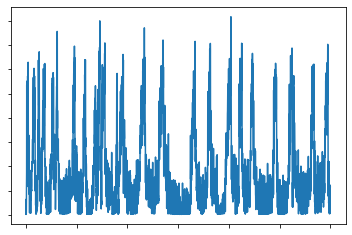

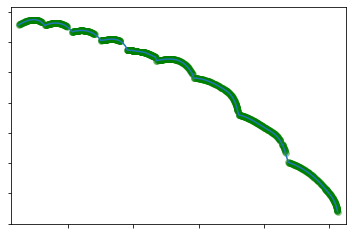

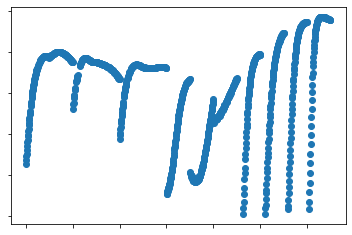

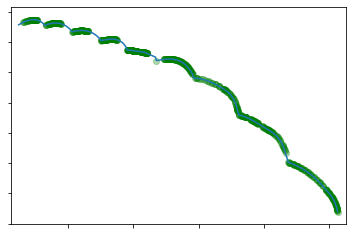

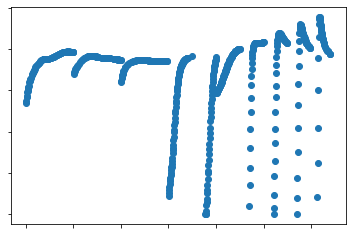

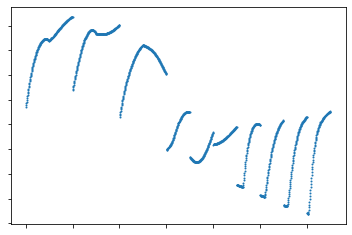

In [50]:
plt.plot(opt[0])

display(opt[1])
display(opt[2])

params = opt[1]['parameters']
bestCase = check_fit(params, min_vals, max_vals, tyrrelCurve, interior, tolerance=0.25)

params = opt[2]['parameters']
finalCase = check_fit(params, min_vals, max_vals, tyrrelCurve, interior, tolerance=0.25)


# Plot time progression
data = bestCase.copy()
time = np.array(data['time'])
time[time < 180] = time[time < 180] + 360
data['time'] = time

plt.figure()
plt.scatter(data['pointNumber'], data['time'],s=1)
plt.title("Time")

In [52]:
cols = ['loss', 'phase', 'obliquity']
df = pd.DataFrame(opt[3], columns=cols).copy()

df['phase'] = df['phase'] * (max_vals[0] - min_vals[0]) + min_vals[0]
df['obliquity'] = df['obliquity'] * (max_vals[1] - min_vals[1]) + min_vals[1]

df
df.to_csv('./output/tyrrelFits.csv', index=False, encoding='utf-8')

In [51]:
opt

(array([0.03889615, 1.26766087, 0.06605837, ..., 1.67570373, 2.44231681,
        2.32826656]),
 {'loss': 0.027633020015865487, 'parameters': array([0.19879015, 0.66392909])},
 {'loss': 2.328266559354931, 'parameters': array([0.11960908, 0.19218547])},
 array([[0.03889615, 0.221     , 0.65011694],
        [1.26766087, 0.17100001, 0.60011697],
        [0.06605837, 0.13152477, 0.56211652],
        ...,
        [1.67570373, 0.13461823, 0.20713484],
        [2.44231681, 0.1294487 , 0.20198648],
        [2.32826656, 0.12436983, 0.19692767]]))